<a href="https://colab.research.google.com/github/Frost-Codes/Scratch-Neural-Net-/blob/main/ScratchNeuralNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Creating a Neural Network from Scratch**

We'll create the neural network using numpy python library. You need to be familiar with basic calculus concepts like:

  *   Power Rule
  *   Constant multiplier rule
  *   Product rule
  *   Quotient rule
  *   chain rule
  *   Derivative of exp and maybe ln
  *   Partial Derivatives

**The basics of a neural net are:**

1. A forward pass where we multiply inputs(X/features) with the weights, add a bias then pass results through an activation function to introduce non-linearlity.

2. Repeat step 1 util you get to output layer where you will use a function of your choice e.g softmax to tailor you output according to your requirements.

3. Calculate the loss of the neural network i.e (Y_target - Y_predictions)...this tells you how far the neural nets predictions are from the true values

4. Calculate the gradient of the loss with respect to the weights and bias for each layer (Calculus)

5. Update weights and bias for each layer (w_new -= learning_rate * w_change)

Learning rate defines the size of the step you take in gradient decent.

In [ ]:
"""
1. We use random values for weights to break symetry...if we used same values of weights all neurons in a layer will compute the same
gradients and thus update in the same way during training. randomness helps model learn different features (Symmetry problems arise when all
neurons in a layer start with the same weights, causing them to update in the same way and learn the same features.)

2. Weights multiplied by 0.01 to avoid large initial values that could lead to vanishing gradient problem especially if we had used sigmoid
or tanh  activation

3. Bias enables the activation function to move up, down, left and right on number graph. They have no symetry problem therefore we initialize
them with zeros for simplicity and practicality

"""

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class NeuralNetwork:

    def __init__(self, input_size, hidden_nodes, output_nodes):
        """
        input_size: number of features (int)
        hidden_nodes: number of hidden nodes (int)
        output_nodes: number of output nodes (int)
        """
        np.random.seed(1)

        self.w1 = np.random.randn(input_size, hidden_nodes) * 0.01
        self.b1 = np.zeros((1, hidden_nodes))

        self.w2 = np.random.randn(hidden_nodes, output_nodes) * 0.01
        self.b2 = np.zeros((1, output_nodes))

    def relu(self, z):
        """
        Relu(x) = max(0 ,x)
        """
        return np.maximum(0, z)

    def sigmoid(self, z):
        """
        Sigmoid activation function
        """
        return 1 / (1 + np.exp(-z)) # formula


    def softmax(self, logit):
        """
        Softmax
        """
        logit = logit - np.max(logit, axis=1, keepdims=True) # we substaract maximum logit value from each logit for numerical stability...prevents large exponentials that could lead to overflow
        exponential = np.exp(logit)
        return exponential / np.sum(exponential, axis=1, keepdims=True)

    def relu_derivative(self, z):
        """
        relu has 2 derivatives case 1: z > 0 (1) case 2: z<=0 (0)
        """
        return np.where(z > 0, 1, 0)

    def one_hot_encode(self, Y):
        """
        One hot encode all classes
        """
        num_classes = np.max(Y) + 1
        one_hot = np.zeros((Y.size, num_classes))

        one_hot[np.arange(Y.size), Y] = 1

        return one_hot

    def one_hot_decode(self, one_hot):
        """
        Decode one hot arrays
        """
        return np.argmax(one_hot, axis=1)


    def categorical_loss(self, y_target, y_prediction):
        """
        Calculates categorical loss
        The logarithm function np.log is undefined for non-positive values (i.e., log(0), log(-1) is
        undefined and can cause numerical instability or infinite values). To prevent this, a very small
        value (in this case, 1e-9) is added to y_prediction for numerical stability

        y_target: true values of y
        y_prediction: predicted values for y
        """
        m = y_target.shape[0] # total predictions
        loss = -np.sum(y_target * np.log(y_prediction + 1e-9)) / m # Divide by number of samples to get avg error
        return loss

    def forward(self, X):
        """
        Does a forward pass
        X: features
        returns: z1, a1, z2, a2
        """
        z1 = np.dot(X, self.w1) + self.b1 # forward pass for hidden layer
        a1 = self.relu(z1)

        z2 = np.dot(a1, self.w2) + self.b2 # forward pass for ouput layer
        a2 = self.softmax(z2)

        return z1, a1, z2, a2

    def backpropagation(self, z1, a1, z2, a2, X, Y):
        m = X.shape[0] # total features

        # Output layer gradients
        dZ2 = a2 - Y # how far predictions are from targets(True values)
        w2_change = np.dot(a1.T, dZ2) / m # dot product of layer input transposed and dZ2 ::gradient of loss with respect to ouput layer weights --> same shape as w2
        b2_change = np.sum(dZ2, axis=0, keepdims=True) / m # sum error on columns then divide by m(sample size) -> normalized matrix same shape as b2

        # Hidden layer gradients
        dA1 = np.dot(dZ2, self.w2.T) # Gradient of activation function of hidden layer..propagates the error backward from output layer to hidden layer
        dZ1 = dA1 * self.relu_derivative(z1) # Undo relu activation and multiply it by gradient of activation function to get Gradient of the Weighted Input of the Hidden Layer
        w1_change = np.dot(X.T, dZ1) / m # Gradient of loss with respect to hidden layer weights --> same shape as w1
        b1_change = np.sum(dZ1, axis=0, keepdims=True) / m # sum error on columns then divide by m(sample size) -> normalized matrix same shape as b1

        return w1_change, b1_change, w2_change, b2_change


    def update_parameters(self, w1_change, b1_change, w2_change, b2_change, learning_rate):
        """"
        Updates weights and bias
        w1_change: change in weight 1
        b1_change: change in bias 1
        w2_change: change in weight 2
        b2_change: change in bias 2
        learning_rate: size of step to take during gradient decent
        """
        self.w1 -= learning_rate * w1_change
        self.b1 -= learning_rate * b1_change
        self.w2 -= learning_rate * w2_change
        self.b2 -= learning_rate * b2_change

    def fit(self, X, Y, epochs, learning_rate):
        """
        X: features
        Y: targets
        epochs: Number of complete presentations of training data to model (int)
        learning_rate: size of step to take during gradient decent
        returns: None: finds optimum values for w1, b1, w2, b2
        """

        learning_rate = np.float32(learning_rate)
        for iteration in range(0, epochs + 1):

            # shuffling data to ensure model does not learn patterns specific to data order
            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
            X = X[indices]
            Y = Y[indices]

            # forward pass
            z1, a1, z2, a2 = self.forward(X)

            # back pass
            w1_change, b1_change, w2_change, b2_change = self.backpropagation( z1, a1, z2, a2, X, Y)

            # update weights
            self.update_parameters(w1_change, b1_change, w2_change, b2_change, learning_rate)

            if iteration % 50 == 0:
                loss = self.categorical_loss(Y, a2)
                print(f"Epoch: {iteration}/{epochs} [{'=' * 30}] Loss: {loss:.4f} - Accuracy: {self.accuracy(X, Y):.2f}")


    def accuracy(self, X, Y):
        """
        X: Features
        Y: Target
        returns: % accuracy of predictions
        """
        prediction = self.forward(X)[-1]
        ind = np.argmax(prediction, axis=1)
        check = np.zeros_like(prediction)
        check[np.arange(check.shape[0]), ind] = 1

        return (np.sum(np.all(check == Y, axis=1)) / check.shape[0]) * 100



    def predict_show(self, X, Y):
        """
        X: feature
        Y: target
        returns: Prediction and display of image
        """
        prediction = self.forward(X)[-1]
        ind = self.one_hot_decode(prediction)
        print(f'Predicted: {ind} actual is: {self.one_hot_decode(Y)}')

        to_plot = X.reshape(28, 28)
        plt.gray()
        plt.imshow(to_plot, interpolation='nearest');
        plt.title(self.one_hot_decode(Y))



**Trying the model on MNIST hand written digits data set**

In [6]:
# Loading data set from keras
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [7]:
# creating training and test sets
x_train = train_images.reshape(train_images.shape[0], train_images.shape[1]* train_images.shape[2]) / 255
y_train = train_labels

x_test = test_images.reshape(test_images.shape[0], test_images.shape[1]* test_images.shape[2]) / 255
y_test = test_labels

In [8]:
print('X_train Shape:', x_train.shape)
print('Y_train shape:', y_train.shape)
print('X_test shape:', x_test.shape)
print('Y_test shape:', y_test.shape)

X_train Shape: (60000, 784)
Y_train shape: (60000,)
X_test shape: (10000, 784)
Y_test shape: (10000,)


In [9]:
"""
Setting some hyperparameters...try changing hidden size to see effect number of hidden nodes has on accuracy and loss

"""
input_size = x_train.shape[1]
hidden_size = 6
output_size = 10
nn = NeuralNetwork(input_size, hidden_size, output_size)

In [10]:
# training
%%time
nn.fit(X=x_train,  Y=nn.one_hot_encode(y_train), epochs=1000, learning_rate=0.1)

Epoch: 0/1000 [==============================] Loss: 2.3028 - Accuracy: 9.52
Epoch: 50/1000 [==============================] Loss: 2.2849 - Accuracy: 34.47
Epoch: 100/1000 [==============================] Loss: 1.8540 - Accuracy: 48.61
Epoch: 150/1000 [==============================] Loss: 1.2066 - Accuracy: 67.72
Epoch: 200/1000 [==============================] Loss: 0.9002 - Accuracy: 76.97
Epoch: 250/1000 [==============================] Loss: 0.7169 - Accuracy: 80.20
Epoch: 300/1000 [==============================] Loss: 0.6270 - Accuracy: 82.02
Epoch: 350/1000 [==============================] Loss: 0.5733 - Accuracy: 83.38
Epoch: 400/1000 [==============================] Loss: 0.5333 - Accuracy: 84.52
Epoch: 450/1000 [==============================] Loss: 0.5001 - Accuracy: 85.63
Epoch: 500/1000 [==============================] Loss: 0.4722 - Accuracy: 86.42
Epoch: 550/1000 [==============================] Loss: 0.4496 - Accuracy: 87.15
Epoch: 600/1000 [===========================

In [12]:
# Accuracy
nn.accuracy(X=x_test, Y=nn.one_hot_encode(y_test))

89.67

Predicted: [6] actual is: [6]


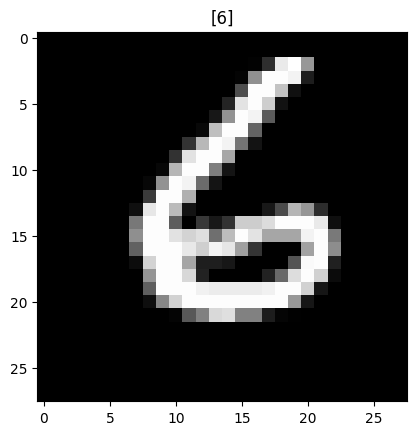

In [19]:
# random image prediction
image = np.random.randint(0, x_test.shape[0])
nn.predict_show(x_test[image], Y=nn.one_hot_encode(y_test[image]))

**Trying model on Fashion MNIST version**

In [2]:
from zipfile import ZipFile
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data_url = 'https://www.kaggle.com/datasets/zalando-research/fashionmnist/data'

In [ ]:
! kaggle datasets download -d zalando-research/fashionmnist

In [5]:
# Extracting files
with ZipFile('fashionmnist.zip') as zp:
  zp.extractall()

In [6]:
# reading data to df
fashion_train = pd.read_csv('./fashion-mnist_train.csv')
fashion_test = pd.read_csv('./fashion-mnist_train.csv')

In [7]:
# Keys
look_up = {0 : 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4:
           'Coat', 5: 'Sandal',6: 'Shirt', 7: 'Sneaker', 8: 'Bag',
           9: 'Ankle boot'}

In [8]:
# df head
fashion_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
print('fashion train shape:',fashion_train.shape)
print('fashion test shape:', fashion_test.shape)

fashion train shape: (60000, 785)
fashion test shape: (60000, 785)


In [10]:
train = np.array(fashion_train)
test = np.array(fashion_test)
x_fashion_train = train[:, 1:] / 255
y_fashion_train = train[:,0]
x_fashion_test = test[:, 1:] / 255
y_fashion_test = test[:,0]

print('X train shape:', x_fashion_train.shape)
print('y train shape:', y_fashion_train.shape)
print('X test shape:', x_fashion_test.shape)
print('y test shape:', y_fashion_test.shape)

X train shape: (60000, 784)
y train shape: (60000,)
X test shape: (60000, 784)
y test shape: (60000,)


Trouser


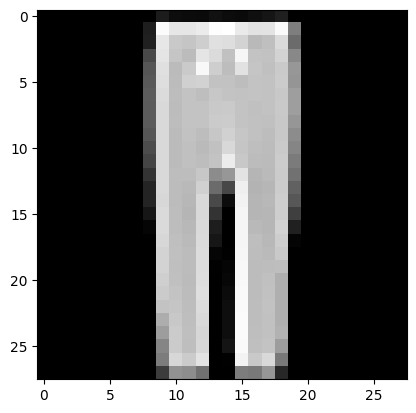

In [12]:
# random image display
image = np.random.randint(0, x_fashion_train.shape[0])
print(look_up[y_fashion_train[image]])
plt.gray()
plt.imshow(x_fashion_train[image].reshape(28, 28));

In [13]:
# setting some hyperparameters
input_size = x_fashion_train.shape[1]
hidden_size = 8
output_size = len(look_up.keys())
fashion_nn = NeuralNetwork(input_size, hidden_size, output_size)

In [14]:
%%time
fashion_nn.fit(X=x_fashion_train,  Y=fashion_nn.one_hot_encode(y_fashion_train), epochs=1000, learning_rate=0.1)

Epoch: 0/1000 [==============================] Loss: 2.3029 - Accuracy: 10.46
Epoch: 50/1000 [==============================] Loss: 1.8310 - Accuracy: 27.96
Epoch: 100/1000 [==============================] Loss: 1.1483 - Accuracy: 60.92
Epoch: 150/1000 [==============================] Loss: 0.9504 - Accuracy: 63.44
Epoch: 200/1000 [==============================] Loss: 0.8377 - Accuracy: 66.06
Epoch: 250/1000 [==============================] Loss: 0.7798 - Accuracy: 69.09
Epoch: 300/1000 [==============================] Loss: 0.7375 - Accuracy: 71.62
Epoch: 350/1000 [==============================] Loss: 0.7021 - Accuracy: 73.51
Epoch: 400/1000 [==============================] Loss: 0.6721 - Accuracy: 74.92
Epoch: 450/1000 [==============================] Loss: 0.6468 - Accuracy: 76.14
Epoch: 500/1000 [==============================] Loss: 0.6253 - Accuracy: 77.06
Epoch: 550/1000 [==============================] Loss: 0.6066 - Accuracy: 77.95
Epoch: 600/1000 [==========================

In [15]:
#checking accuracy
fashion_nn.accuracy(X=x_fashion_test, Y = fashion_nn.one_hot_encode(y_fashion_test))

81.76833333333333

Dress
Predicted: [3] actual is: [3]


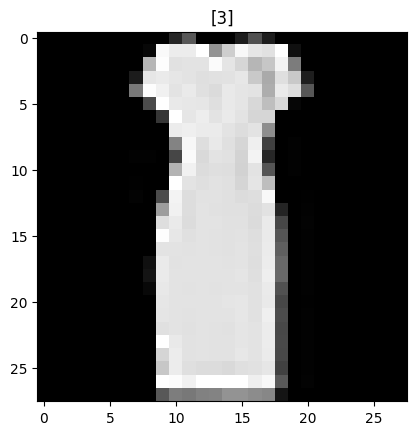

In [23]:
# picking random image and making prediction
image = np.random.randint(0, x_fashion_train.shape[0])
print(look_up[y_fashion_test[image]])
fashion_nn.predict_show(X=x_fashion_test[image], Y=fashion_nn.one_hot_encode(y_fashion_test[image]))